In [58]:
import copy
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

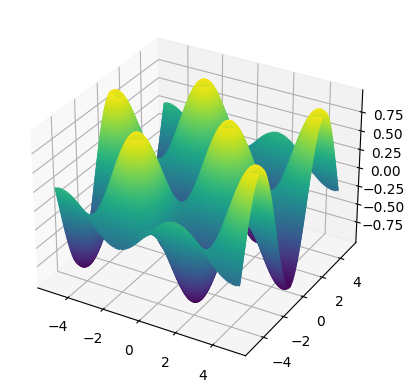

In [59]:
num_of_samples = 100
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y = np.meshgrid(x_data, y_data)
Z = np.sin(X)*np.cos(Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 200)
plt.show()

In [60]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1), Z.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [61]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x
    
model = ELM(2, 100, 1)

In [62]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T)
H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
T = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [63]:
def infGain(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        x, y = x.reshape(-1, 2), y.reshape(-1, 1)
        preds = model(x)
        loss += torch.norm(preds - y) 
    return loss

def prune(model, loader):
    inf = []
    model.eval()
    with torch.no_grad():
        for i in range(model.fc1.out_features):
            fc1_weight_temp = copy.deepcopy(model.fc1.weight.data[i])
            fc1_bias_temp = copy.deepcopy(model.fc1.bias.data[i])
            fc2_weight_temp = copy.deepcopy(model.fc2.weight.data[:,i])
            model.fc1.weight.data[i] = 0
            model.fc1.bias.data[i] = 0
            model.fc2.weight.data[:,i] = 0
            inf.append(infGain(model, loader))
            model.fc1.weight.data[i] = fc1_weight_temp
            model.fc1.bias.data[i] = fc1_bias_temp
            model.fc2.weight.data[:,i] = fc2_weight_temp
        neuron_to_prune = np.argmin(inf)
        pruned_model = ELM(1, model.fc1.out_features-1, 1)
        pruned_model.fc1.weight.data = torch.cat([model.fc1.weight.data[:neuron_to_prune], model.fc1.weight.data[neuron_to_prune+1:]])
        pruned_model.fc1.bias.data = torch.cat([model.fc1.bias.data[:neuron_to_prune], model.fc1.bias.data[neuron_to_prune+1:]])
        pruned_model.fc2.weight.data = torch.cat([model.fc2.weight.data[:,:neuron_to_prune],model.fc2.weight.data[:,neuron_to_prune+1:]], dim=1)
    return pruned_model

for _ in range(2):
    model = prune(model, testloader)

V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T)
H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
T = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

Train error: 6.540038177162735e-06
Test error: 9.388314541845851e-06


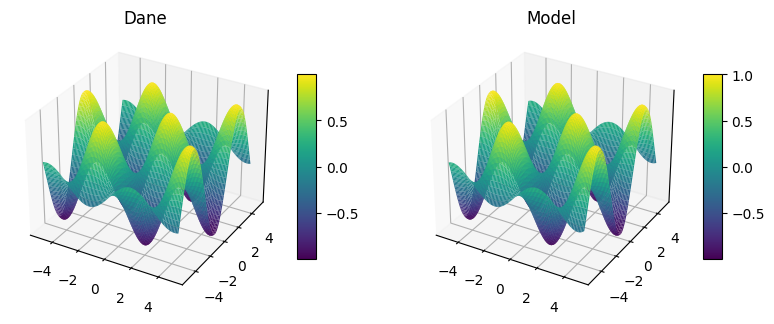

In [64]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 2))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 2))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
X, Y = np.meshgrid(x_data, y_data)
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Dane')
fig.colorbar(surf, shrink=0.5, aspect=10)

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X, Y, model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(num_of_samples, num_of_samples), rstride=1, cstride=1, cmap='viridis')
ax.set_zticks([])
ax.set_title('Model')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

In [65]:
import plotly.graph_objects as go

predictions = model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1)
trace1 = go.Scatter3d(
    x=X.reshape(-1),
    y=Y.reshape(-1),
    z=Z.reshape(-1) - predictions,
    mode='markers',
    marker=dict(
        size=2,
        color=Z.reshape(-1) - predictions,
        colorscale='Viridis',
        colorbar=dict(title='Data - predicitions'),
    ),
    name='Model'
)
fig = go.Figure(data=[trace1], layout=dict(width=700, height=500))
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[-5,5]),
        yaxis = dict(range=[-5,5]),
        zaxis = dict(range=[-0.1,0.1]),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10)
)
fig.show()

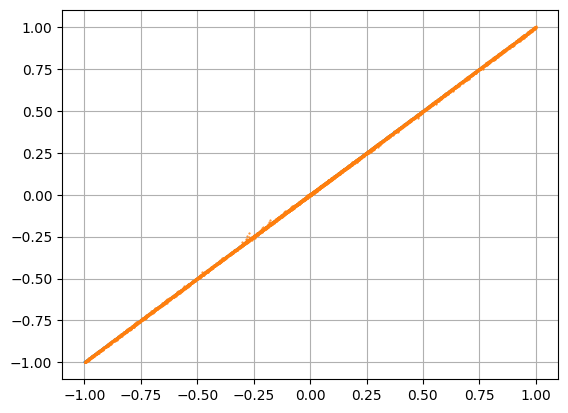

In [66]:
plt.plot([np.min(Z), np.max(Z)], [np.min(Z), np.max(Z)])
plt.plot(Z.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.grid()
plt.show()